In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import tensorflow as tf
import numpy as np
import string
import json

2024-02-03 00:43:02.148705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 00:43:02.148810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 00:43:02.302002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the Dataset

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2024-02-03 00:43:16--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: '/tmp/sarcasm.json'

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2024-02-03 00:43:16 (49.3 MB/s) - '/tmp/sarcasm.json' saved [5643545/5643545]



In [3]:
# A list of all the stopwords that will be filtered in the dataset
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

In [4]:
# Creating a String Translation table to order the words while filtering
table = str.maketrans("", "", string.punctuation) 

## Filtering the Dataset

In [5]:
# Loading the JSON File
with open("/tmp/sarcasm.json", "r") as json_file:
    loaded_json = json.load(json_file)
    
# Filtering the Contents of the File
labels = []
sentences = []
links = []

for example in loaded_json:
    
    # Decoding the JSON File into a string
    sentence = example["headline"].lower()
    
    # Extending spaces between the punctuations
    sentence = sentence.replace(",", " , ") 
    sentence = sentence.replace(".", " . ") 
    sentence = sentence.replace("-", " - ") 
    sentence = sentence.replace("/", " / ")
    
    # Removing all the HTML Tags
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    
    # Filtering the Stopwords and Punctuations
    filtered_sentence = ""
    words = sentence.split()
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    
    sentences.append(filtered_sentence)
    labels.append(example["is_sarcastic"])
    links.append(example["article_link"])
    
print("No of Sentences: ", len(sentences))
print("No of Targets: ", len(labels))
print("No of Links: ", len(links))

/tmp/ipykernel_26/3022695663.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


No of Sentences:  26709
No of Targets:  26709
No of Links:  26709


In [6]:
print("Some Filtered Sentences:\n")
for sentence in sentences[:5]:
    print(sentence)

Some Filtered Sentences:

former versace store clerk sues secret black code minority shoppers 
roseanne revival catches thorny political mood  better worse 
mom starting fear sons web series closest thing will grandchild 
boehner just wants wife listen  not come alternative debt  reduction ideas 
j  k  rowling wishes snape happy birthday magical way 


## Visualisation the Distribution of Sentence Lenghts

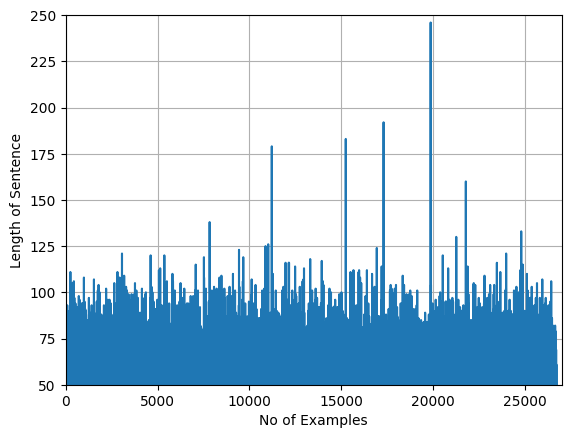

In [7]:
xs = []
ys = []
current_item = 1

for sentence in sentences:
    xs.append(current_item)
    ys.append(len(sentence))
    current_item += 1

# Viewing the Lengths of Sentences as a Sorted List
#sorted_ys = sorted(ys)
#plt.plot(xs, sorted_ys)

plt.plot(xs, ys)
plt.axis([0, 27e3, 50, 250])
plt.xlabel("No of Examples")
plt.ylabel("Length of Sentence")
plt.grid()
plt.show()

## Splitting the Dataset

In [8]:
training_sentences, training_labels = sentences[:23000], labels[:23000]
test_sentences, test_labels = sentences[23000:], labels[23000:]

print("No of Training Examples: ", len(training_sentences))
print("No of Testing Examples: ", len(test_sentences))

No of Training Examples:  23000
No of Testing Examples:  3709


## Tokenizing the Sentences

In [9]:
# Initialsing the Tokenizer
sarcasm_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=50000, oov_token="<OOV>"
)

# Fitting the Tokenizer on Text
sarcasm_tokenizer.fit_on_texts(training_sentences)
word_index = sarcasm_tokenizer.word_index

In [10]:
# Converting the Sentences to Sequences
train_sequences = sarcasm_tokenizer.texts_to_sequences(training_sentences)
test_sequences = sarcasm_tokenizer.texts_to_sequences(test_sentences)

print("Some of the Encoded Sequences:\n")
for seq in train_sequences[:5]:
    print(seq)

Some of the Encoded Sequences:

[231, 13209, 637, 3418, 2445, 283, 44, 1749, 2653, 9427]
[7407, 3144, 3145, 7408, 314, 2446, 195, 900]
[87, 803, 753, 862, 2038, 501, 5214, 136, 7, 9428]
[1257, 6, 146, 315, 1566, 5, 224, 2447, 1425, 6093, 863]
[702, 754, 5215, 947, 9429, 537, 458, 1305, 42]


In [11]:
# Padding the Sequences
pad_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequences, maxlen=100, truncating="post", padding="post"
)

pad_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences, maxlen=100, truncating="post", padding="post"
)

print("Some of the Padded Sequences:\n")
for seq in pad_train[:5]:
    print(seq)

Some of the Padded Sequences:

[  231 13209   637  3418  2445   283    44  1749  2653  9427     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[7407 3144 3145 7408  314 2446  195  900    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

**Analysing the Word Count as given by the Tokenizer**

In [12]:
# sarcasm_tokenizer.word_counts.items()

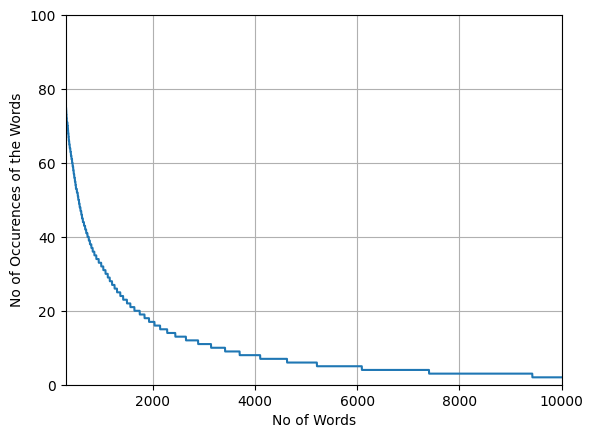

In [13]:
# Taking the Word Counts for each word tokenized
word_count = sarcasm_tokenizer.word_counts

# Ordering the Items in the Dictionary in order of Frequency
ordered_dict = (OrderedDict(sorted(word_count.items(), key=lambda word: word[1], reverse=True)))

xs = []
ys = []
current_item = 1
for item in ordered_dict:
    xs.append(current_item)
    ys.append(ordered_dict[item])
    current_item += 1

plt.plot(xs, ys)
plt.xlabel("No of Words")
plt.ylabel("No of Occurences of the Words")
plt.axis([300, 10000, 0, 100])
plt.grid()
plt.show()

## Converting the Sequences from Lists to Arrays

In [14]:
train_array = np.array(pad_train)
train_labels = np.array(training_labels)

test_array = np.array(pad_test)
test_labels = np.array(test_labels)

print("Training Array: ", train_array.shape)
print("Training Labels: ", train_labels.shape)
print("Testing Array: ", test_array.shape)
print("Testing Labels: ", test_labels.shape)

Training Array:  (23000, 100)
Training Labels:  (23000,)
Testing Array:  (3709, 100)
Testing Labels:  (3709,)


## Building the Model

In [15]:
tf.keras.backend.clear_session()

In [16]:
nlp_model = tf.keras.models.Sequential([
    
    # Embedding Layer:
    # - Vocab_Size (1st Arg): This should be the same as num_words of the Tokenizer.
    # - Embedding_Dim (2nd Arg): This creates a 16-dimensional vector for each word.
    # - The dimensions of the embedding vector will over time learn the relative meanings of each word through BackPropagation.
    tf.keras.layers.Embedding(50000, 16),
    
    # GlobalAvgPool1D:
    # This layer averages the parameters learnt over all the dimensions to provide an 
    # output of fixed length to the hidden layers.
    tf.keras.layers.GlobalAvgPool1D(),
    
    # Hidden Layers
    tf.keras.layers.Dense(24, activation="relu"),
    
    # Output Layer for Binary Classification of is_sarcastic
    tf.keras.layers.Dense(1, activation="sigmoid")
])

nlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          800000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 800433 (3.05 MB)
Trainable params: 800433 (3.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Compiling the Model**

In [17]:
nlp_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

## Training the Model

In [18]:
history = nlp_model.fit(
    train_array, train_labels, 
    validation_data=(test_array, test_labels),
    epochs=15
)

Epoch 1/15


I0000 00:00:1706921010.065371      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


719/719 [==============================] - 18s 21ms/step - loss: 0.6839 - accuracy: 0.5590 - val_loss: 0.6765 - val_accuracy: 0.5700
Epoch 2/15
719/719 [==============================] - 4s 6ms/step - loss: 0.5984 - accuracy: 0.6753 - val_loss: 0.4997 - val_accuracy: 0.7625
Epoch 3/15
719/719 [==============================] - 4s 5ms/step - loss: 0.3903 - accuracy: 0.8399 - val_loss: 0.4300 - val_accuracy: 0.7967
Epoch 4/15
719/719 [==============================] - 3s 5ms/step - loss: 0.2999 - accuracy: 0.8783 - val_loss: 0.4185 - val_accuracy: 0.8053
Epoch 5/15
719/719 [==============================] - 3s 4ms/step - loss: 0.2449 - accuracy: 0.9047 - val_loss: 0.4224 - val_accuracy: 0.8075
Epoch 6/15
719/719 [==============================] - 3s 5ms/step - loss: 0.2049 - accuracy: 0.9227 - val_loss: 0.4363 - val_accuracy: 0.8110
Epoch 7/15
719/719 [==============================] - 3s 5ms/step - loss: 0.1723 - accuracy: 0.9367 - val_loss: 0.4585 - val_accuracy: 0.8072
Epoch 8/15
719/

## Performance Analysis

In [19]:
def plot_graph(history, metric):
    
    # Training score of the Metric
    plt.plot(history.history[metric])
    
    # Validation score of the Metric
    plt.plot(history.history["val_" + metric])
    
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend([metric, "val_" + metric])
    plt.show()

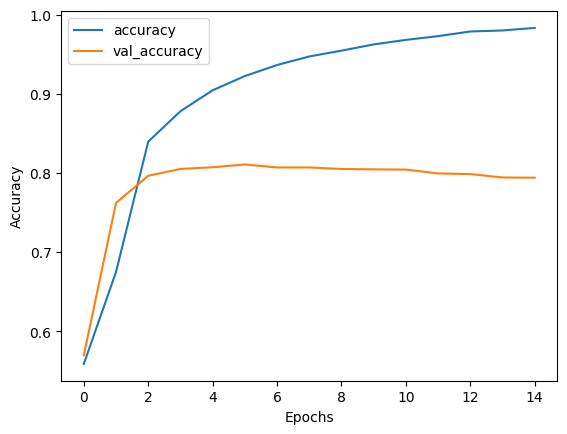

In [20]:
# Viewing the Accuracy Comparison
plot_graph(history, "accuracy")

**Inference**
- Although the Training accuracy is increasing there is signs of **`overfitting`**.
- Many of the words in the Test set may not be seen by the model during training.

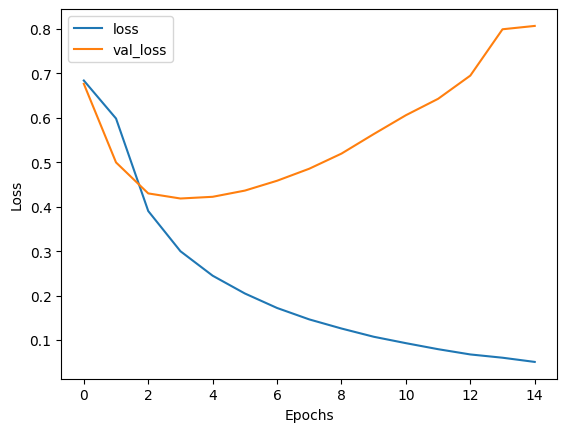

In [21]:
# Viewing the Loss Comparison
plot_graph(history, "loss")

**Inference**
- By the Contrasting performance of the model on the training and testing sets its clear that the model is overfitting to the training set

## Reducing the Overfitting in Language Models

**Reducing the Learning Rate**

In [22]:
tf.keras.backend.clear_session()

In [23]:
test_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000, 16),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [24]:
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False
)

test_model.compile(
    loss="binary_crossentropy", metrics=["accuracy"], optimizer=adam
)

In [25]:
# Re-training the Model
history = test_model.fit(
    train_array, train_labels, validation_data=(test_array, test_labels),
    epochs=60, verbose=1
)

Epoch 1/60
719/719 [==============================] - 12s 15ms/step - loss: 0.6878 - accuracy: 0.5521 - val_loss: 0.6829 - val_accuracy: 0.5700
Epoch 2/60
719/719 [==============================] - 4s 5ms/step - loss: 0.6848 - accuracy: 0.5596 - val_loss: 0.6819 - val_accuracy: 0.5700
Epoch 3/60
719/719 [==============================] - 3s 4ms/step - loss: 0.6838 - accuracy: 0.5596 - val_loss: 0.6808 - val_accuracy: 0.5700
Epoch 4/60
719/719 [==============================] - 4s 5ms/step - loss: 0.6822 - accuracy: 0.5596 - val_loss: 0.6793 - val_accuracy: 0.5700
Epoch 5/60
719/719 [==============================] - 3s 4ms/step - loss: 0.6792 - accuracy: 0.5596 - val_loss: 0.6760 - val_accuracy: 0.5700
Epoch 6/60
719/719 [==============================] - 3s 4ms/step - loss: 0.6747 - accuracy: 0.5596 - val_loss: 0.6713 - val_accuracy: 0.5700
Epoch 7/60
719/719 [==============================] - 4s 5ms/step - loss: 0.6671 - accuracy: 0.5601 - val_loss: 0.6638 - val_accuracy: 0.5724
Epoc

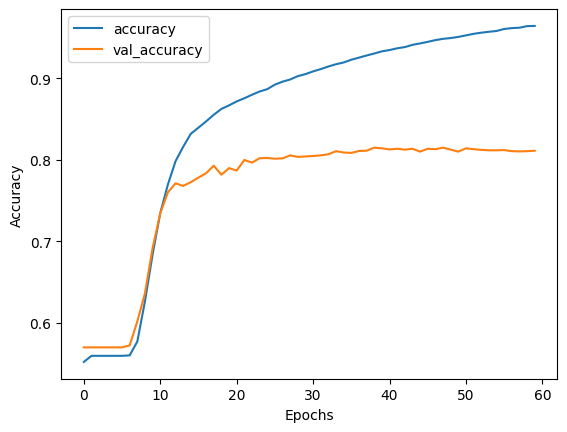

In [26]:
plot_graph(history, "accuracy")

**Inference**
- We can compare the graphs to above and below to see that rate of overfitting in the model has been reduced and is seen much later in training.
- Even though the model doesnt learn anything in the start the loss is decreasing showing that the model is finding better patterns.

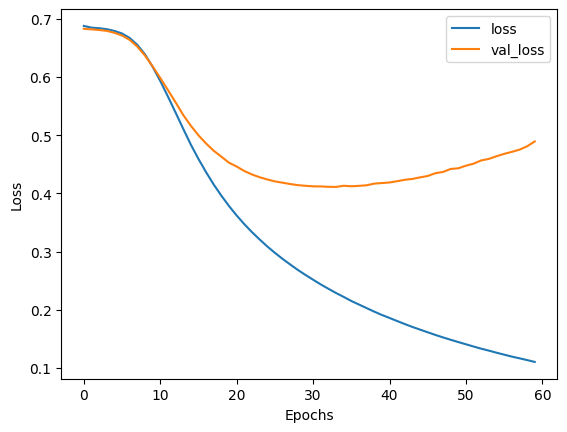

In [27]:
plot_graph(history, "loss")

**Exploring the Vocabulary**

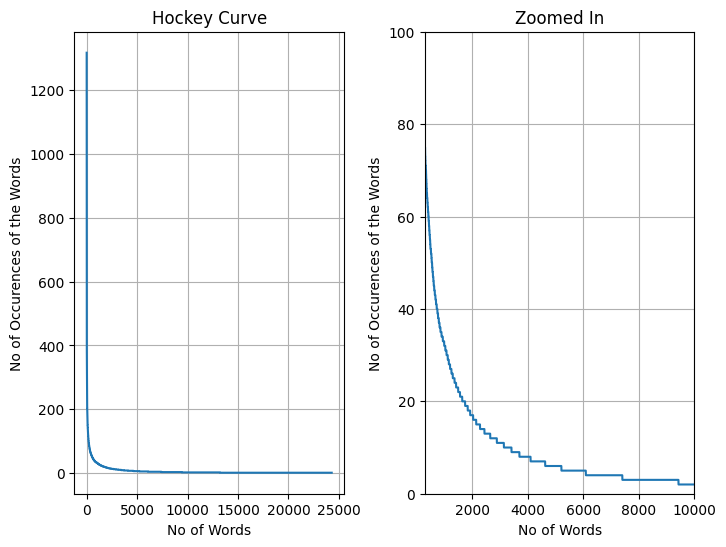

In [28]:
# Taking the Word Counts for each word tokenized
word_count = sarcasm_tokenizer.word_counts

# Ordering the Items in the Dictionary in order of Frequency
ordered_dict = (OrderedDict(sorted(word_count.items(), key=lambda word: word[1], reverse=True)))

# Acquiring the frequency of different words
xs = []
ys = []
current_item = 1
for item in ordered_dict:
    xs.append(current_item)
    ys.append(ordered_dict[item])
    current_item += 1
    
# Adjusting the Plot Layout
plt.figure(figsize=(8, 6))

# Viewing the No of Words with High Frequency vs Low Frequency
plt.subplot(1, 2, 1)
plt.plot(xs, ys)
plt.title("Hockey Curve")
plt.xlabel("No of Words")
plt.ylabel("No of Occurences of the Words")
plt.grid()

# Viewing the Average Frequency of Most Words
plt.subplot(1, 2, 2)
plt.plot(xs, ys)
plt.title("Zoomed In")
plt.xlabel("No of Words")
plt.ylabel("No of Occurences of the Words")
plt.axis([300, 10000, 0, 100])
plt.grid()

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

**Inference**
- We can see that most of the words are having an average frequency of 60 or less.
- Thus the overfitting is taking place as the no of words with less occurrences is more, they might have a good chance of not being seen in the training set.
- Thus when the model sees them for the first time in the test set it cannot predict the meaning.
- Further due to the stark contrast in the no_of_words and frequency the embeddings need to include an additional weight to reduce the overfitting when learning each word.

**Reducing the Embedding Size**
- Since there are about 2000 words whose frequency is greater than 20 we reduce the size of the Embedding to create a richer perception for these words utilising the dimensions of the embedding layer.

In [29]:
tf.keras.backend.clear_session()

In [30]:
red_embed_model = tf.keras.models.Sequential([
    
    # Reducing the Vocabulary size of the Embeddings
    tf.keras.layers.Embedding(2000, 16),
    tf.keras.layers.GlobalAvgPool1D(),
    
    # Hidden Layers
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

red_embed_model.compile(
    loss="binary_crossentropy", 
    metrics=["accuracy"], 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
)

red_embed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          32000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 32433 (126.69 KB)
Trainable params: 32433 (126.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history = red_embed_model.fit(
    train_array, train_labels,
    validation_data=(test_array, test_labels),
    epochs=50, verbose=1
)

Epoch 1/50
719/719 [==============================] - 15s 20ms/step - loss: 0.6885 - accuracy: 0.5498 - val_loss: 0.6836 - val_accuracy: 0.5700
Epoch 2/50
719/719 [==============================] - 5s 7ms/step - loss: 0.6853 - accuracy: 0.5596 - val_loss: 0.6825 - val_accuracy: 0.5700
Epoch 3/50
719/719 [==============================] - 3s 4ms/step - loss: 0.6846 - accuracy: 0.5596 - val_loss: 0.6819 - val_accuracy: 0.5700
Epoch 4/50
719/719 [==============================] - 3s 5ms/step - loss: 0.6838 - accuracy: 0.5596 - val_loss: 0.6810 - val_accuracy: 0.5700
Epoch 5/50
719/719 [==============================] - 4s 5ms/step - loss: 0.6827 - accuracy: 0.5596 - val_loss: 0.6798 - val_accuracy: 0.5700
Epoch 6/50
719/719 [==============================] - 4s 5ms/step - loss: 0.6811 - accuracy: 0.5596 - val_loss: 0.6779 - val_accuracy: 0.5700
Epoch 7/50
719/719 [==============================] - 3s 5ms/step - loss: 0.6787 - accuracy: 0.5596 - val_loss: 0.6755 - val_accuracy: 0.5700
Epoc

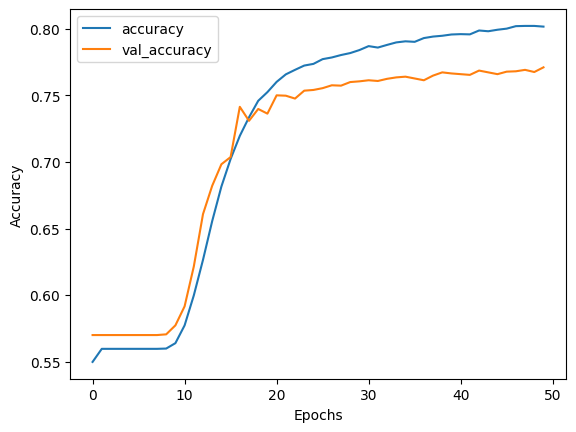

In [32]:
plot_graph(history, "accuracy")

**Inference**
- As in the graphs above and below we can see that the **`Loss`** and **`Accuracy`** over the **`Training and Validation`** sets is converging better.
- Most of the Overfitting is being removed.

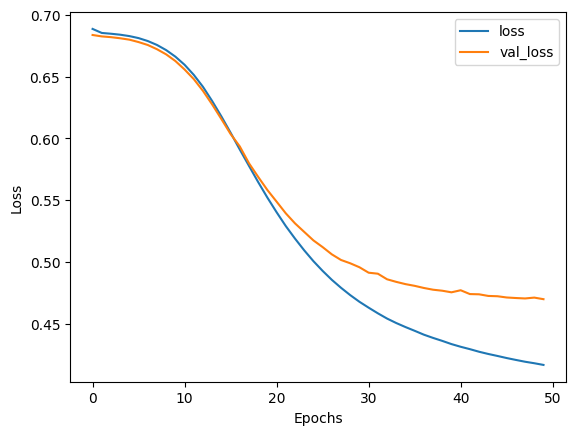

In [33]:
plot_graph(history, "loss")

**Reducing the Embedding Dimensions**
- Due to the reduced size in the Embedding Vocabulary, we can row reduce the dimensions on the embedding layer while gaining rich perception of the dataset
<br><br>
$$ embedding \; dims = \sqrt[4]{vocabulary \; size} $$

In [34]:
embed_dim = round(2000 ** (1/4))
print(embed_dim)

7


In [35]:
tf.keras.backend.clear_session()

In [36]:
red_embed_dims_model = tf.keras.models.Sequential([
    
    # Reduced Embedding Size and Dimensions
    tf.keras.layers.Embedding(2000, embed_dim),
    tf.keras.layers.GlobalAvgPool1D(),
    
    # Hidden Layers
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

red_embed_dims_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
)

red_embed_dims_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 7)           14000     
                                                                 
 global_average_pooling1d (  (None, 7)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                192       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 14217 (55.54 KB)
Trainable params: 14217 (55.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = red_embed_dims_model.fit(
    train_array, train_labels,
    validation_data=(test_array, test_labels),
    epochs=60, verbose=1
)

Epoch 1/60
719/719 [==============================] - 16s 21ms/step - loss: 0.6889 - accuracy: 0.5596 - val_loss: 0.6849 - val_accuracy: 0.5700
Epoch 2/60
719/719 [==============================] - 4s 6ms/step - loss: 0.6859 - accuracy: 0.5596 - val_loss: 0.6833 - val_accuracy: 0.5700
Epoch 3/60
719/719 [==============================] - 4s 5ms/step - loss: 0.6855 - accuracy: 0.5596 - val_loss: 0.6829 - val_accuracy: 0.5700
Epoch 4/60
719/719 [==============================] - 3s 5ms/step - loss: 0.6852 - accuracy: 0.5596 - val_loss: 0.6826 - val_accuracy: 0.5700
Epoch 5/60
719/719 [==============================] - 4s 5ms/step - loss: 0.6849 - accuracy: 0.5596 - val_loss: 0.6823 - val_accuracy: 0.5700
Epoch 6/60
719/719 [==============================] - 3s 5ms/step - loss: 0.6845 - accuracy: 0.5596 - val_loss: 0.6817 - val_accuracy: 0.5700
Epoch 7/60
719/719 [==============================] - 3s 4ms/step - loss: 0.6840 - accuracy: 0.5596 - val_loss: 0.6812 - val_accuracy: 0.5700
Epoc

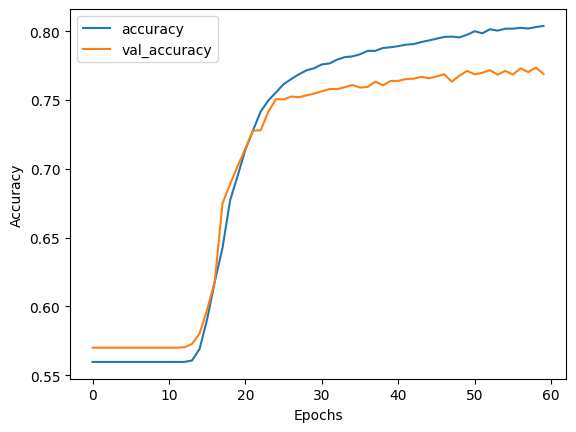

In [38]:
plot_graph(history, "accuracy")

**Inference**
- Reducing the Embedding Dimesions has increased the speed of training the model
- Further from the graphs above and below it is clear that the model is now converging with very little overfitting

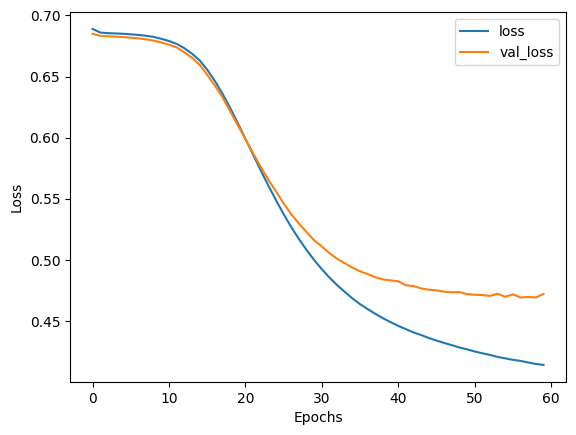

In [39]:
plot_graph(history, "loss")

**Altering the Model Architecture**
- Since the Embedding Dimesions has been reduced to 7, the GlobalAvgPooling() provides a 7 - row vector to the Hidden Layer.
- Thus placing 24 Neurons for 7 row input is an overkill.
- Further we can implement **`Dropout Layers and Regularization`** to remove overfitting in the Hidden Layers while training.
- Using **`Dropout Layers or Regularization`** is also an overkill for the model as there are very few units in the hidden layers.

In [40]:
tf.keras.backend.clear_session()

In [41]:
red_embed_dims_arch_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(2000, embed_dim),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

red_embed_dims_arch_model.compile(
    loss="binary_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

red_embed_dims_arch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 7)           14000     
                                                                 
 global_average_pooling1d (  (None, 7)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 14073 (54.97 KB)
Trainable params: 14073 (54.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
history = red_embed_dims_arch_model.fit(
    train_array, train_labels,
    validation_data=(test_array, test_labels),
    epochs=60, verbose=1
)

Epoch 1/60
719/719 [==============================] - 11s 14ms/step - loss: 0.6921 - accuracy: 0.5525 - val_loss: 0.6907 - val_accuracy: 0.5700
Epoch 2/60
719/719 [==============================] - 4s 6ms/step - loss: 0.6903 - accuracy: 0.5596 - val_loss: 0.6889 - val_accuracy: 0.5700
Epoch 3/60
719/719 [==============================] - 3s 5ms/step - loss: 0.6890 - accuracy: 0.5596 - val_loss: 0.6875 - val_accuracy: 0.5700
Epoch 4/60
719/719 [==============================] - 3s 4ms/step - loss: 0.6881 - accuracy: 0.5596 - val_loss: 0.6864 - val_accuracy: 0.5700
Epoch 5/60
719/719 [==============================] - 3s 4ms/step - loss: 0.6873 - accuracy: 0.5596 - val_loss: 0.6855 - val_accuracy: 0.5700
Epoch 6/60
719/719 [==============================] - 4s 5ms/step - loss: 0.6865 - accuracy: 0.5596 - val_loss: 0.6838 - val_accuracy: 0.5700
Epoch 7/60
719/719 [==============================] - 3s 5ms/step - loss: 0.6851 - accuracy: 0.5596 - val_loss: 0.6827 - val_accuracy: 0.5700
Epoc

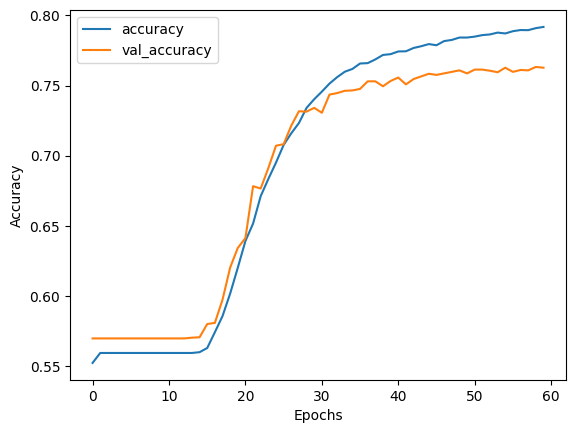

In [43]:
plot_graph(history, "accuracy")

**Inference**
- From the Graphs Above and Below we can see that the model has converged with lesser units.
- Further remving the extra units has smoothened the graphs.
- The overfitting is now mostly removed

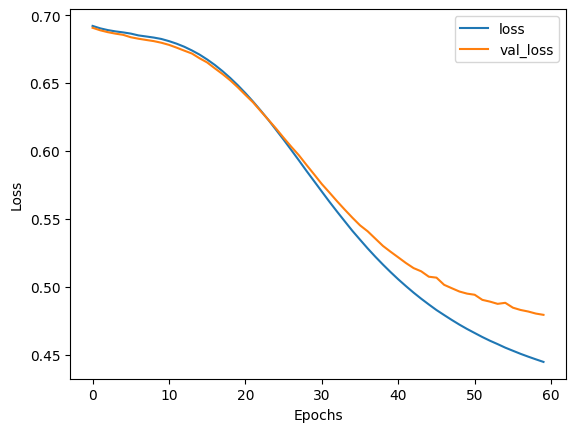

In [44]:
plot_graph(history, "loss")

## Making Predictions with the Model

In [45]:
test_sentences = [
    "I am not saying I hate you, what I'm saying is you are literally the Monday of my life",
    "It's ok if you dont like me, not everyone has a good taste",
    "I'm sorry while you were talking I was trying to figure out where the hell did you get the idea that I ever cared",
    "No you dont have to repeat yourself, I was ignoring you the first time around",
    "If this works, I will be super happy cause I have finally built an entire Natural Language Processing project by myself"
]

In [46]:
# Encoding the Test Sentences using the Tokenizer
final_seq = sarcasm_tokenizer.texts_to_sequences(test_sentences)

print("The Final Sentences after Encoding:\n")
for seq in final_seq:
    print(seq)

The Final Sentences after Encoding:

[1, 1, 5, 1051, 1, 582, 1, 1, 1, 1051, 1, 1, 1, 1824, 1, 1456, 1, 1, 28]
[1, 2635, 1, 1, 100, 21, 1, 5, 199, 1, 1, 66, 2270]
[1, 1371, 1, 1, 1, 477, 1, 1, 188, 1, 1587, 1, 1, 1, 533, 1, 1, 23, 1, 436, 1, 1, 137, 20256]
[22, 1, 100, 1, 1, 3590, 1, 1, 1, 3616, 1, 1, 19, 20, 129]
[1, 1, 1399, 1, 7, 1, 327, 537, 1373, 1, 1, 161, 3033, 1, 203, 2264, 2725, 22666, 1126, 1, 1]


In [47]:
# Padding the Sequences to the Model Input Shape
final_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(
    final_seq, padding="post", truncating="post", maxlen=100
)

print("The Final Sentences after Padding:\n")
for seq in final_seq_pad:
    print(seq)

The Final Sentences after Padding:

[   1    1    5 1051    1  582    1    1    1 1051    1    1    1 1824
    1 1456    1    1   28    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[   1 2635    1    1  100   21    1    5  199    1    1   66 2270    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

In [48]:
# Making Predictions
print(red_embed_dims_arch_model.predict(final_seq_pad))

1/1 [==============================] - 0s 100ms/step
[[0.1437439 ]
 [0.60694295]
 [0.78908676]
 [0.66305095]
 [0.54056543]]


**Inference**
- Greater the Number the move the sentence is intended to be sarcastic.
- Out of 4 Sarcastic Sentence, the model has misclassified only 1 (phew!!! 😮‍💨 I guess most of the words in the first sentence werent in the tokenizers word index)
- The Non Sarcastic Sentence has been classified correctly but with a fine margin (I guess Ill take that for now 🙂)

## Visualising the Embeddings

**Reversing the Word Index to store the values for Embedding Projection**

In [49]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

print("Reversed Word Index Dictionary:\n")
for word_id in list(reverse_word_index.items())[:5]:
    print(word_id)

Reversed Word Index Dictionary:

(1, '<OOV>')
(2, 'new')
(3, 'trump')
(4, 'man')
(5, 'not')


**Extracting the Weights of Vectors from the Embedding Layers**

In [50]:
# Accessing the Embedding Layer
embed_vec = red_embed_dims_arch_model.layers[0]

# Accessing the Weights
weights = embed_vec.get_weights()[0]
print("Weights Shape: ", weights.shape)

Weights Shape:  (2000, 7)


**Viewing the Weights of the Words**

In [51]:
part_rev_word_idx = list(reverse_word_index.items())[1 : 6]
part_weight = weights[1 : 6]

print("Words from the Word Index and their respective Weights in the Embedding Layer:\n")
for i in range(5):
    print(part_rev_word_idx[i], "\t", part_weight[i])

Words from the Word Index and their respective Weights in the Embedding Layer:

(2, 'new') 	 [-0.02839804  0.01323665  0.00493509 -0.03554453  0.03208146 -0.01593568
  0.00170386]
(3, 'trump') 	 [-0.47061056 -0.42592534 -0.40707168 -0.53822374  0.5145185  -0.44421262
 -0.45865703]
(4, 'man') 	 [ 0.39778686  1.0054464   1.0186667   0.9996507  -0.59330165  1.0263227
  1.0047939 ]
(5, 'not') 	 [-1.4378346 -1.3975171 -1.3758924 -1.4674165  1.3891071 -1.4365314
 -1.4752394]
(6, 'just') 	 [-0.18943979 -0.1345916  -0.15303107 -0.08630535  0.14517139 -0.14511803
 -0.08491491]


**Creating the files for the Embedding Projector**

In [52]:
import io

out_vec = io.open("vectors.tsv", "w", encoding="utf-8")
out_meta = io.open("meta_data.tsv", "w", encoding="utf-8")

for word_num in range(1, 2000):
    
    # Acquiring the Words and their corresponding weights
    word = reverse_word_index[word_num]
    embedding = weights[word_num]
    
    # Storing the Values
    out_vec.write("\t".join([str(x) for x in embedding]) + "\n")
    out_meta.write(word + "\n")
    
# Closing the Files
out_vec.close()
out_meta.close()

## The Embedding Projection

**Heads up**
*If the Image below is not displayed you can check the resources of the project to find the screenshot 🙃* <br><br>

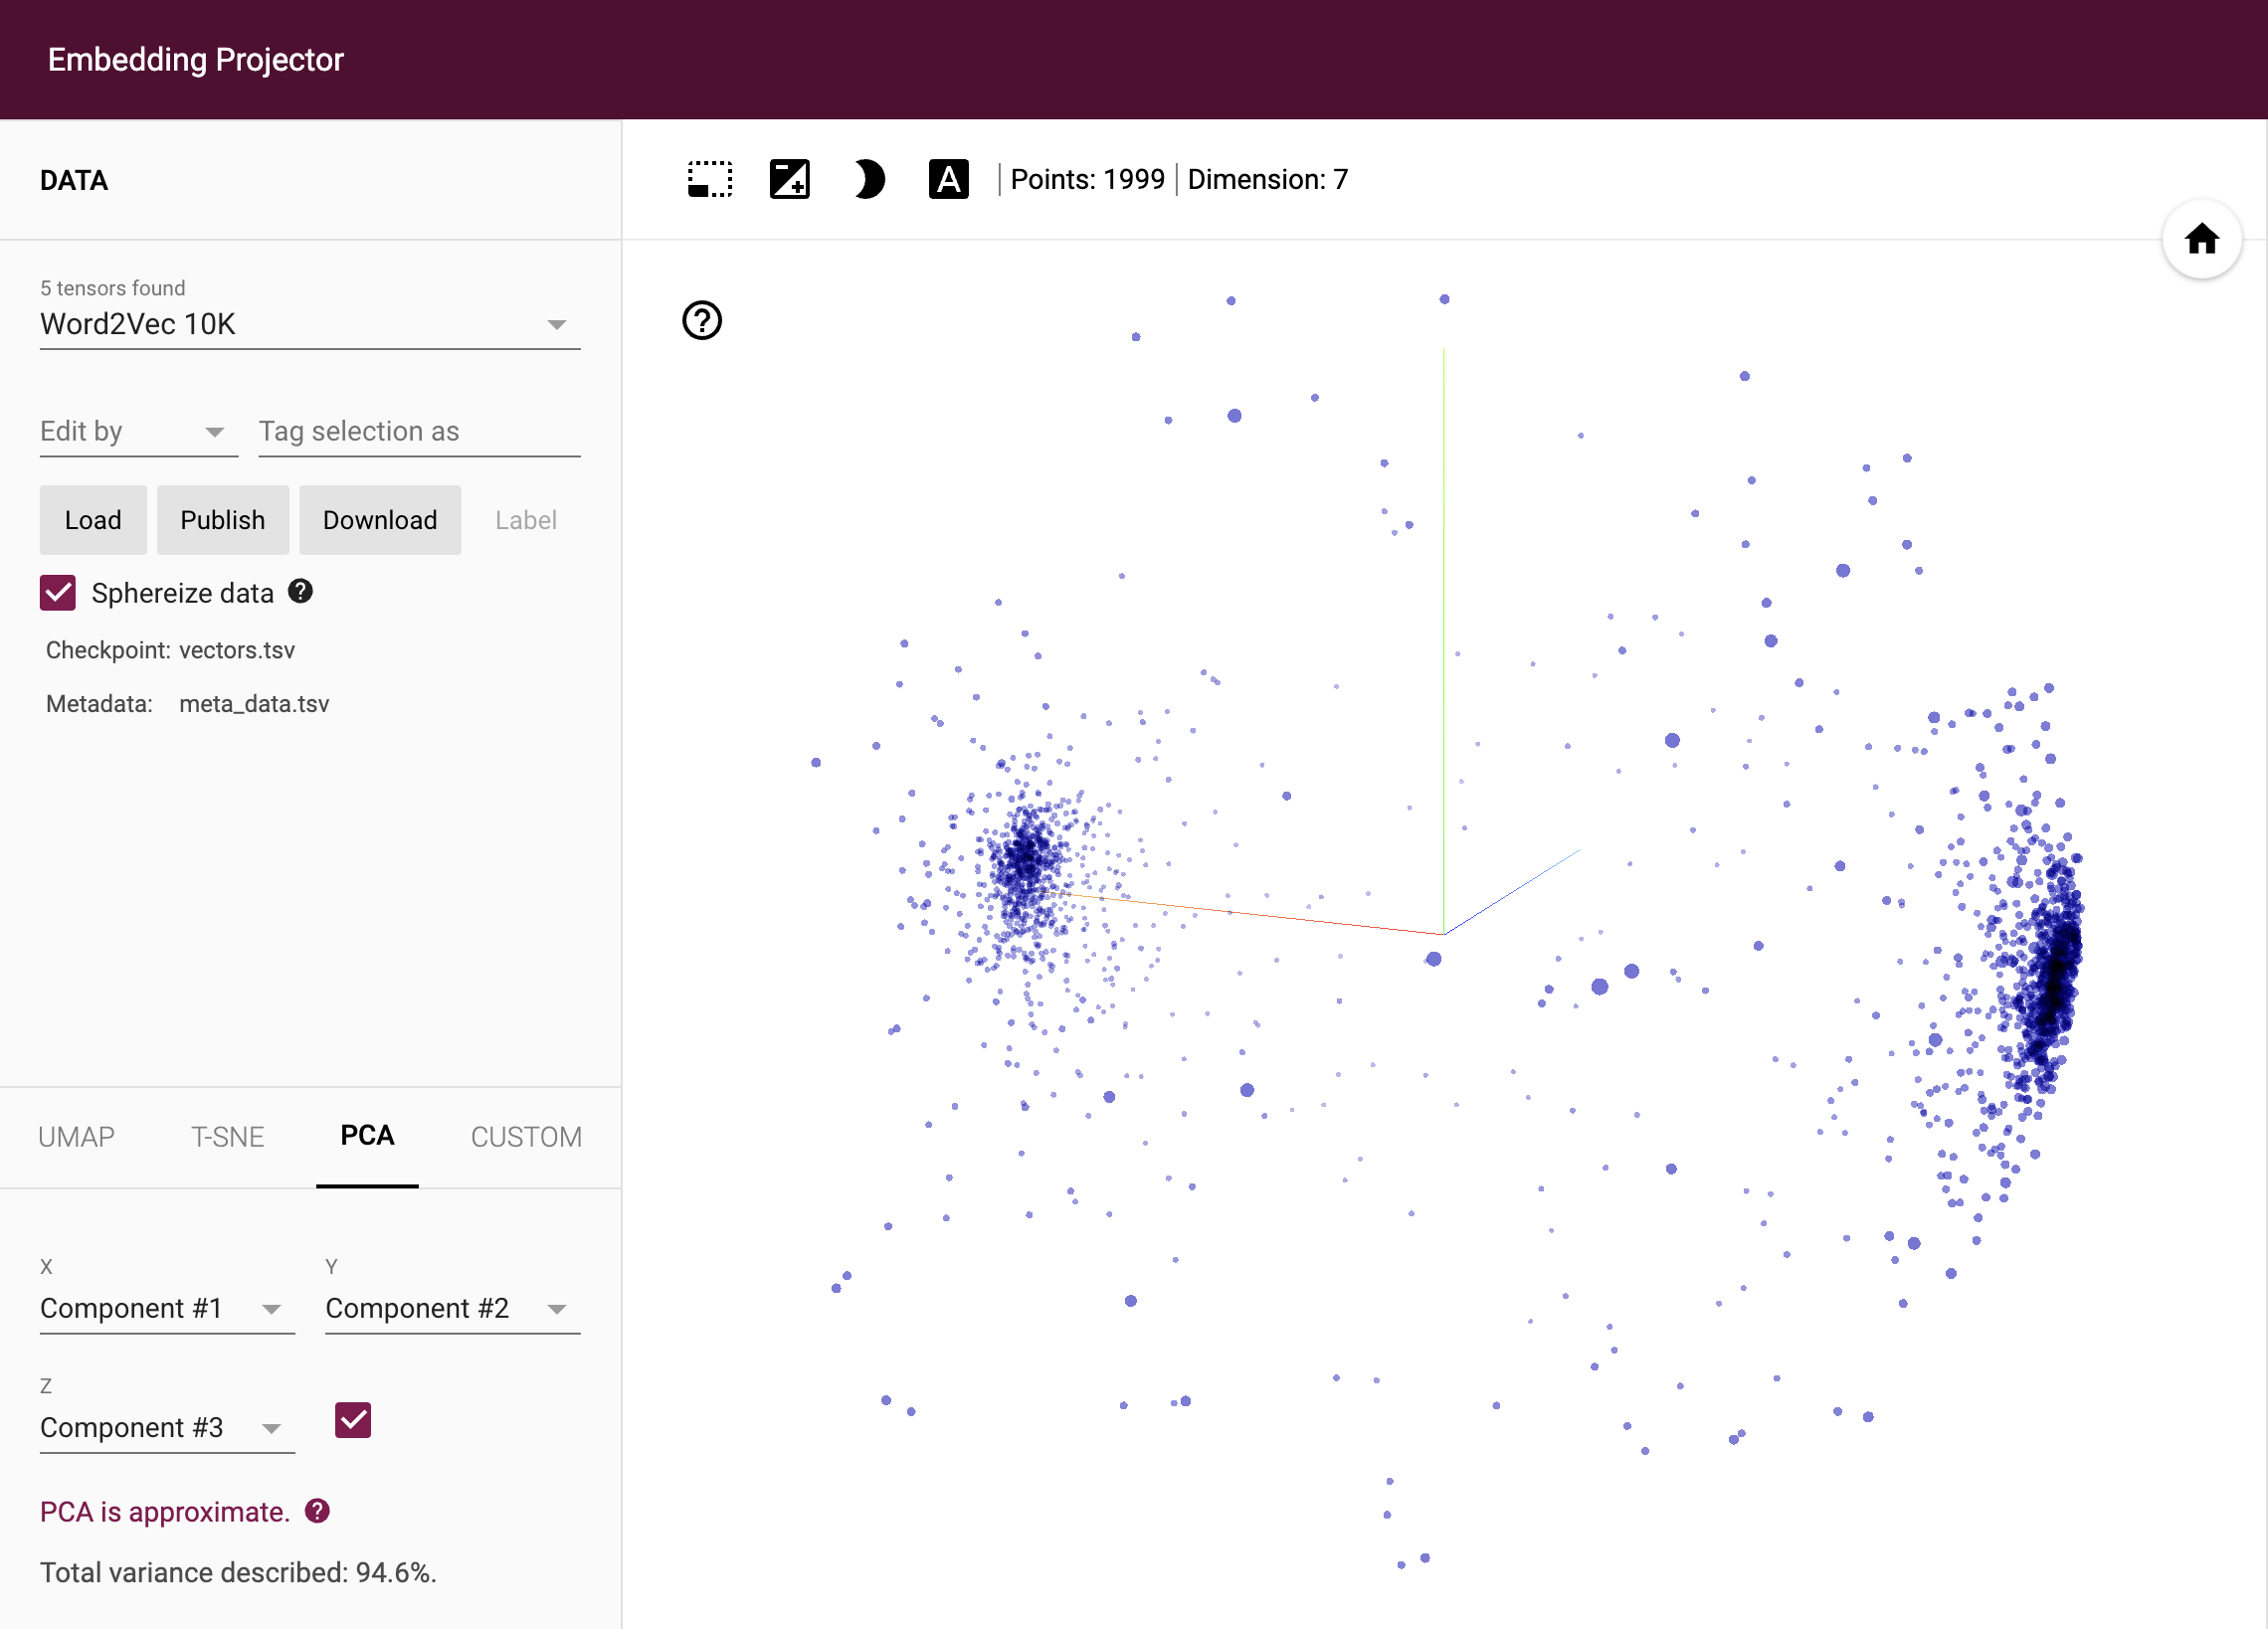

### <b>I have had a lot of fun making this Kernal 🙃</b>
### <b> Hope you had fun reading it 🙂</b>